## Домашнее задание 6  
Обучить сиамскую сеть для верификации лиц на датасете LFW  
Библиотеки: [Python, Tensorflow]

In [0]:
%tensorflow_version 2.x

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

import tensorflow as tf
import tensorflow_datasets as tfds

##Загрузка датасета LFW

In [0]:
train_ds, ds_info = tfds.load(
    'lfw',
    as_supervised=True,
    with_info=True,
    split='train',
)

Shuffling and writing examples to /root/tensorflow_datasets/lfw/0.1.0.incompleteZ4982E/lfw-train.tfrecord



Dataset lfw downloaded and prepared to /root/tensorflow_datasets/lfw/0.1.0. Subsequent calls will reuse this data.


In [0]:
ds_info

tfds.core.DatasetInfo(
    name='lfw',
    version=0.1.0,
    description='Labeled Faces in the Wild:
        A Database for Studying Face Recognition in
        Unconstrained Environments',
    homepage='http://vis-www.cs.umass.edu/lfw',
    features=FeaturesDict({
        'image': Image(shape=(250, 250, 3), dtype=tf.uint8),
        'label': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=13233,
    splits={
        'train': 13233,
    },
    supervised_keys=('label', 'image'),
    citation="""@TechReport{LFWTech,
        author = {Gary B. Huang and Manu Ramesh and Tamara Berg and Erik Learned-Miller},
        title = {Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments},
        institution = {University of Massachusetts, Amherst},
        year = 2007,
        number = {07-49},
        month = {October}
    }""",
    redistribution_info=,
)

Label: b'Tom_Amstutz'
Label: b'Kimi_Raikkonen'


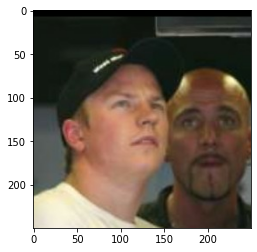

In [0]:
for example in train_ds.take(2):
    image, label = example[1], example[0]

    plt.imshow(image.numpy().astype(np.float32)/255)
    print(f"Label: {label}")

##Создание модели CNN

In [0]:
EMB_SIZE = 250

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(EMB_SIZE, activation=None),
])

##Contrastive Loss

In [0]:
MARGIN = 50.0

def contastive_loss(embs, labels):
    bs = embs.shape[0]
    embs1 = embs[:bs//2, :]
    embs2 = embs[bs//2:, :]
    labels1 = labels[:bs//2]
    labels2 = labels[bs//2:]

    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
    d =  tf.sqrt(d2)
    z = tf.cast(labels1 == labels2, tf.float32)
    
    return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)

##Подготовка пайплайна данных

In [0]:
def normalize_example(label, image):
    return label, tf.cast(image, tf.float32) / 255.

In [0]:
BATCH_SIZE = 128
NUM_EPOCHS = 10

train_ds = train_ds.map(normalize_example)
train_ds = train_ds.shuffle(buffer_size=10000, seed=5)
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE)

In [0]:
train_ds

<DatasetV1Adapter shapes: ((None,), (None, 250, 250, 3)), types: (tf.string, tf.float32)>

##Визуализация датасета

In [0]:
some_sample = next(iter(train_ds))
images = some_sample[1].numpy()[:4]
labels = some_sample[0].numpy()[:4]

In [0]:
labels

array([b'Mahmoud_Abbas', b'Harrison_Ford', b'Ruth_Stubbs',
       b'Stefano_Basalini'], dtype=object)

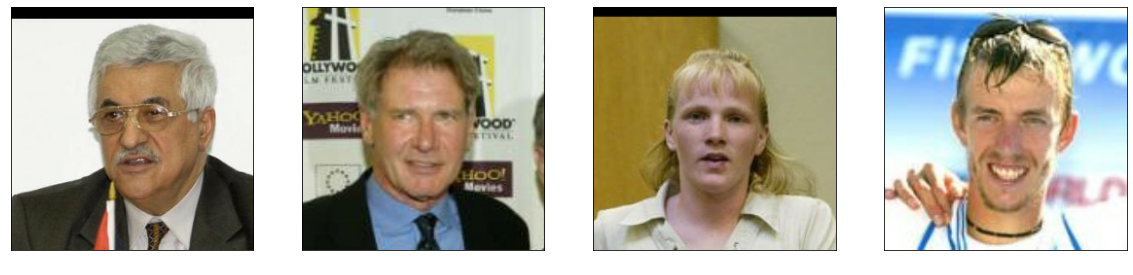

In [0]:
fontdict = {'fontsize': '14', 'color': 'white'}
plt.figure(figsize=(20,10))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(images[i].reshape(250,250,3))
    plt.xlabel(labels[i].decode(), fontdict=fontdict)
plt.show()

##Подготовка к обучению

In [0]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

##Обучение модели

In [0]:
%%time

for iteration, (labels, images) in enumerate(train_ds):
    
    # Forward
    with tf.GradientTape() as tape:
        embs = model(images)
        loss_value = contastive_loss(embs, labels)
        
    # Backward
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))

    if iteration % 200 == 0:
        print('[{}] Loss: {}'.format(iteration, loss_value.numpy()))

[0] Loss: 2463.8203125
[200] Loss: 10.157177925109863
[400] Loss: 0.2099279910326004
[600] Loss: 0.029348894953727722
[800] Loss: 13.649984359741211
[1000] Loss: 2.6853561401367188
CPU times: user 4min 5s, sys: 1min 13s, total: 5min 19s
Wall time: 5min 22s


##Тестирование на новых данных

In [0]:
def load_and_prepare_image(fpath):
    import imageio
    from skimage.transform import resize
    img = imageio.imread(fpath, pilmode="RGB")
    img = img.astype(np.float32)/255
    img = resize(img, (250, 250, 3), mode='reflect', anti_aliasing=True)
    img = np.reshape(img, (250, 250, 3))
    return img

img_a1 = load_and_prepare_image('Arnold_1.jpeg')
img_a2 = load_and_prepare_image('Arnold_2.jpg')
img_b = load_and_prepare_image('Stalone.jpg')
img_c = load_and_prepare_image('Chan.jpg')

##Получение эмбеддингов для новых данных

In [0]:
new_embs = model(np.stack((img_a1, img_a2, img_b, img_c), axis=0))

In [0]:
img_a1 = load_and_prepare_image('Arnold_1.jpeg')
img_a2 = load_and_prepare_image('Arnold_2.jpg')
img_b = load_and_prepare_image('Stallone.jpg')
img_c = load_and_prepare_image('Chan.jpg')

In [2]:
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5

emb1 = new_embs[0,:] #Arnold_1
emb2 = new_embs[1,:] #Arnold_1
emb3 = new_embs[2,:] #Stallone
emb4 = new_embs[3,:] #Chan

print('Arnold_1 <-> Arnold_1: ', diff(emb1, emb2))
print('Arnold_1<-> Stallone: ', diff(emb1, emb3))
print('Arnold_2 <-> Stallone: ', diff(emb2, emb3))
print('Arnold_1<-> Chan: ', diff(emb1, emb4))
print('Arnold_2<-> Chan: ', diff(emb2, emb4))

Arnold_1 <-> Arnold_1: 58.33445009383847
Arnold_1<-> Stallone: 121.2458127723241
Arnold_2 <-> Stallone: 112.67404547894813
Arnold_1<-> Chan: 127.56157367375569
Arnold_2<-> Chan: 153.71051088038064


Эмбеддинги фотографий Арнольда Шварценеггера оказались ближе, чем эмбеддинги фотографий других людей.